In [31]:
#!pip install --upgrade botocore==1.23.26
#!pip install --upgrade urllib3==1.22.0
#!pip install py7zr
#!pip install s3fs
#!git clone https://github.com/InseeFrLab/cartogether.git
#%cd ./cartogether
#!pip install -r requirements.txt
#!pip install .
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartogether
#!pip install pandas fiona shapely pyproj rtree
#!pip install contextily
#!pip install geopandas
#!pip install pygeos
#!pip install geopy
#!pip install pynsee[full]

In [2]:
import contextily as ctx
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

/opt/mamba/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [51]:
import pynsee
from pynsee.utils.init_conn import init_conn

N=100000

init_conn(insee_key="k32RC1ZJH8RV4Llh6kTRakU15tca", insee_secret="CTnVGRLchI7dbJOlrvYbrOyIfnMa")
data = pynsee.search_sirene(variable = ["activitePrincipaleEtablissement"],
                       pattern = "10.71C", kind = 'siret', number=N)

data = data.loc[data['dateFin'].isnull()]
df=data[["activitePrincipaleEtablissement","codePostalEtablissement","libelleCommuneEtablissement"]]

Token has been created
!!! Please subscribe to BDM API on api.insee.fr !!!
!!! Please subscribe to Metadata API on api.insee.fr !!!
!!! Please subscribe to Local Data API on api.insee.fr !!!


In [47]:
df=df.dropna()
liste_departements=["75","77","78","91","92","93","94","95"]
department=[]
for ville in df.codePostalEtablissement:
    department.append(ville[:2])
df['departement']=department
df=df[df.activitePrincipaleEtablissement=="10.71C"]
df=df[df.departement.isin(liste_departements)]
df

,activitePrincipaleEtablissement,codePostalEtablissement,libelleCommuneEtablissement,departement
72,10.71C,78450,VILLEPREUX,78
74,10.71C,75007,PARIS 7,75
82,10.71C,78200,MAGNANVILLE,78
117,10.71C,94240,L'HAY-LES-ROSES,94
122,10.71C,91100,CORBEIL-ESSONNES,91
...,...,...,...,...
2585,10.71C,95190,GOUSSAINVILLE,95
2593,10.71C,78980,BREVAL,78
2598,10.71C,75005,PARIS 5,75
2599,10.71C,75005,PARIS 5,75


In [48]:
def get_location(adress):
    geolocator = Nominatim(user_agent="tutorial")
    location = geolocator.geocode(adress)
    return((location.latitude, location.longitude))

def get_location_all(commerces):
    geom = []
    liste_long=[]
    liste_lat=[]
    for k in range(len(commerces)):
        try:
            loc1,loc2=get_location(commerces.iloc[k,1]+" "+commerces.iloc[k,2])
            geom.append(Point(loc1,loc2))
            liste_long.append(loc2)
            liste_lat.append(loc1)
        except Exception:
            commerces=commerces.drop(df.index[k])
    commerces = commerces.set_geometry(geom)
    commerces['long']=liste_long
    commerces['lat']=liste_lat
    return(commerces)

In [49]:
df=get_location_all(df)
df

,activitePrincipaleEtablissement,codePostalEtablissement,libelleCommuneEtablissement,departement,geometry,long,lat
72,10.71C,78450,VILLEPREUX,78,POINT (48.832 2.007),2.007049,48.832301
74,10.71C,75007,PARIS 7,75,POINT (48.863 2.344),2.343882,48.863175
82,10.71C,78200,MAGNANVILLE,78,POINT (48.968 1.685),1.684743,48.968104
117,10.71C,94240,L'HAY-LES-ROSES,94,POINT (48.779 2.337),2.337302,48.779051
122,10.71C,91100,CORBEIL-ESSONNES,91,POINT (48.614 2.482),2.481809,48.613773
...,...,...,...,...,...,...,...
2545,10.71C,77124,CREGY-LES-MEAUX,77,POINT (49.032 2.473),2.473363,49.032317
2565,10.71C,75004,PARIS 4,75,POINT (48.945 1.533),1.533184,48.944745
2585,10.71C,95190,GOUSSAINVILLE,95,POINT (20.864 106.668),106.668239,20.864294
2593,10.71C,78980,BREVAL,78,POINT (20.864 106.668),106.668239,20.864294


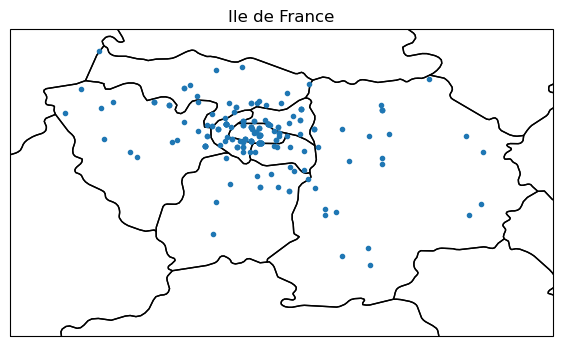

In [50]:
#!pip install cartopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([1.3, 3.6, 48, 49.3])

ax.add_feature(cfeature.STATES)
ax.plot(df.long, df.lat, '.')
ax.set_title('Ile de France');